In [1]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import time
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')


In [2]:
class Run:
    def __init__(self, file, nevents):
        self.file = Path(file) 
        self.nevents = nevents

        # Root file variables 
        self.meta_data = None
        self.output_data = None
        # Is Online
        self.pmt_is_online = None 
        # Hit cleaning masks
        self.hit_amp_mask = None
        self.hit_charge_mask = None
        self.hit_time_mask = None        
        self.hit_tof = None
        self.event_hit_times = None
        self.hit_time_res = None
        # Hit cleaned data
        self.clean_charges = None
        self.clean_nhit = None
        # Event selection masks 
        self.fid_vol_event_mask = None
        self.prompt_raw_mask = None
        self.delayed_raw_mask = None 
        self.prompt_clean_mask = None 
        self.delayed_clean_mask = None 
        # Event selected data
        self.delayed_dt = None
        self.delayed_dt_mask = None 
        self.final_event_mask = None 
        self.final_background_mask = None
        self.final_charges = None 
        self.background_charges = None
        # Timing variables for plotting
        self.clock_period = 0.5  # us
        self.start_time = 1 #3 * 0.432 + self.clock_period # 0  # e.g., 0.864 us
        self.nclock_cycles_to_plot = 40
        self.stop_time = self.start_time + (self.nclock_cycles_to_plot) * self.clock_period  # e.g., 0.912
        # PMT ids for plotting  
        self.barrel_ids = None 
        self.bottom_ids = None 
        self.dichroic_ids = None 
        self.top_ids = None 
        self.behind_ids = None 

    def print_nevents_in_file(self):
        f = up.open(self.file)
        print(f"There are {f['output'].num_entries} events in {self.file}")

    def load_meta_data(self):
        f = up.open(self.file)
        print(f"Meta Keys: {f['meta'].keys()}")
        start = time.time() 
        self.meta_data = f['meta'].arrays([
            'pmtType',
            'pmtId',
            'pmtChannel',
            'pmtIsOnline',
            'pmtCableOffset',
            'pmtX',
            'pmtY',
            'pmtZ',
        ], entry_start=0, entry_stop=1, library='ak') 
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load meta data for {self.nevents} events")

    def load_event_data(self):
        f=up.open(self.file)
        print(f"Output Keys: {f['output'].keys()}")
        start = time.time()
        self.output_data = f['output'].arrays([
            'timestamp',
            'triggerTime',
            'timeSinceLastTrigger_us',
            'digitPMTID',
            'digitTime',
            'digitCharge',
            'digitHitCleaningMask',
            'x_quadfitter',
            'y_quadfitter',
            'z_quadfitter',
            'validposition_quadfitter',
            'time_quadfitter',
            'validtime_quadfitter',
            'x_seedndestroy',
            'y_seedndestroy',
            'z_seedndestroy',
            'validposition_seedndestroy',
            'time_seedndestroy',
            'validtime_seedndestroy',
        ], entry_start=0, entry_stop=self.nevents, library='ak')
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load output data for {self.nevents} events")

    # step 0
    def calculate_time_residuals(self,snd=True):
        
        # Which fitter to use 
        if snd:
            event_time = self.output_data['time_seedndestroy']
            fitx = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['x_seedndestroy'])[1]
            fity = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['y_seedndestroy'])[1]
            fitz = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['z_seedndestroy'])[1]
            valid_fit = self.output_data['validtime_seedndestroy'] & self.output_data['validposition_seedndestroy']
        else:
            event_time = self.output_data['time_quadfitter']
            fitx = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['x_seedndestroy'])[1]
            fity = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['y_seedndestroy'])[1]
            fitz = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['z_seedndestroy'])[1]
            valid_fit = self.output_data['validtime_quadfitter'] & self.output_data['validposition_quadfitter']

        valid_fit = self.output_data['validtime_quadfitter'] & self.output_data['validposition_quadfitter']
        hit_time = self.output_data['digitTime']
        event_time = ak.broadcast_arrays(hit_time, event_time)[1]
        self.event_hit_times = event_time
        pmtX = ak.Array(self.meta_data['pmtX'][0])
        pmtY = ak.Array(self.meta_data['pmtY'][0])
        pmtZ = ak.Array(self.meta_data['pmtZ'][0])
        hitx_flat = pmtX[ak.flatten(self.output_data['digitPMTID'])]
        hity_flat = pmtY[ak.flatten(self.output_data['digitPMTID'])]
        hitz_flat = pmtZ[ak.flatten(self.output_data['digitPMTID'])]
        hitx = ak.unflatten(hitx_flat, ak.num(self.output_data['digitPMTID']))
        hity = ak.unflatten(hity_flat, ak.num(self.output_data['digitPMTID']))
        hitz = ak.unflatten(hitz_flat, ak.num(self.output_data['digitPMTID'])) 
        dist = np.sqrt((fitx - hitx)**2 + (fity - hity)**2 + (fitz - hitz)**2)
        hit_tof = dist / 224 # speed of light in water [mm/ns]
        #self.hit_tof = ak.where(valid_fit, hit_tof, np.nan)
        self.hit_tof = hit_tof
        hit_time_res = hit_time - event_time - hit_tof 
        print("fit",ak.sum(valid_fit),ak.sum(~valid_fit))
        valid_fit = ak.broadcast_arrays(hit_time, valid_fit)[1]
        self.hit_time_res = ak.where(valid_fit, hit_time_res, np.nan)
        print(ak.sum(np.isnan(self.hit_time_res)), ak.sum(np.isnan(self.hit_time_res),axis=1))# step 1.5 verify timing corrections in step 1

    def plot_timing_corrections(self, nbins=400, trange=(-20,20), figsize=(8,8), fontsize=10, loc='upper right',clim=(1e0,1e5)):

        plt.figure(figsize=figsize)
        # Raw times
        times = self.output_data['digitTime']
        trigger_time = self.output_data['triggerTime']
        plt.hist(ak.flatten(times), bins=nbins, range=trange, histtype='step',label='Digit Hit Time', color='blue')\
        # Event (fit) time correction
        times_ev = times - self.event_hit_times
        plt.hist(ak.flatten(times_ev), bins=nbins, range=trange, histtype='step', label='Digit Hit Time - Reco Event Time', color='orange')
        # Time-of-flight correction
        times_ev_tof = times_ev - self.hit_tof
        plt.hist(ak.flatten(times_ev_tof), bins=nbins, range=trange, histtype='step', label='Digit Hit Time - Reco Event Time - TOF', color='green')
        times_trig_ev_tof = times_ev_tof - trigger_time
        plt.hist(ak.flatten(times_trig_ev_tof), bins=nbins, range=trange, histtype='step', label='Digit Hit Time - Reco Event Time - TOF - Trigger', color='black')
        plt.ylim(clim)
        plt.xlabel('Hit Time [ns]')
        plt.ylabel('Counts')
        plt.title('Hit Times Across All Channels and Events')
        plt.legend(loc=loc,fontsize=fontsize)
        plt.tight_layout()
        plt.yscale('log')
        plt.show()


    # step 1
    def make_hit_cleaning_masks(self,time_cut):

        # Amplitude mask 
        self.hit_amp_mask = ((self.output_data['digitHitCleaningMask'] >> 1) & 1) == 0
        # Charge mask 
        charge = self.output_data['digitCharge']
        self.hit_charge_mask = charge > 0
        # Timing mask 
        self.hit_time_mask = (self.hit_time_res > time_cut[0]) & (self.hit_time_res < time_cut[1])



    # step 2
    def make_cleaned_and_raw_nhit_masks(self, prompt_min_nhit=125, delayed_min_nhit=50):

        # Get raw data
        charges = self.output_data['digitCharge']

        # Apply hit cuts individually for diagnostics   
        amp_charges = ak.mask(charges, self.hit_amp_mask)
        charge_charges = ak.mask(charges, self.hit_charge_mask) 
        time_charges = ak.mask(charges, self.hit_time_mask)

        # Apply all hit cuts together
        clean_charges = ak.mask(charges, self.hit_amp_mask & self.hit_time_mask & self.hit_charge_mask)

        # Calculate NHits
        raw_nhit = ak.count(charges, axis=1)
        amp_nhit = ak.count(amp_charges, axis=1)
        charge_nhit = ak.count(charge_charges, axis=1) 
        time_nhit = ak.count(time_charges, axis=1)
        clean_nhit = ak.count(clean_charges, axis=1)

        # Save important stuff
        self.clean_charges = clean_charges
        self.clean_nhit = clean_nhit

        # Make trigger type masks 
        prompt_raw_mask = raw_nhit >= prompt_min_nhit
        delayed_raw_mask = (raw_nhit >= delayed_min_nhit) & (raw_nhit < prompt_min_nhit)
        prompt_clean_mask = clean_nhit >= prompt_min_nhit
        delayed_clean_mask = (clean_nhit >= delayed_min_nhit) & (clean_nhit < prompt_min_nhit)

        # Save important stuff
        self.prompt_clean_mask = prompt_clean_mask 
        self.delayed_clean_mask = delayed_clean_mask
        self.prompt_raw_mask = prompt_raw_mask 
        self.delayed_raw_mask = delayed_raw_mask


    # step 2.5 verify effects of step 2
    def plot_cleaned_and_raw_charges(self,hist_nbins=200,hist_crange=(-10,10),fontsize=20,figsize=(10,5)):

        # Get charges
        charges = self.output_data['digitCharge']
        amp_charges = ak.mask(charges, self.hit_amp_mask)
        charge_charges = ak.mask(charges, self.hit_charge_mask) 
        time_charges = ak.mask(charges, self.hit_time_mask)
        clean_charges = ak.mask(charges, self.hit_amp_mask & self.hit_time_mask & self.hit_charge_mask)

        # Flatten for plotting
        charges = ak.to_numpy(ak.flatten(charges))
        amp_charges = ak.to_numpy(ak.flatten(amp_charges))
        charge_charges = ak.to_numpy(ak.flatten(charge_charges))
        time_charges = ak.to_numpy(ak.flatten(time_charges))
        clean_charges = ak.to_numpy(ak.flatten(clean_charges))

        # Plot total charge
        plt.figure(figsize=figsize)
        plt.hist(charges,bins=hist_nbins,range=hist_crange,histtype='step',color='black',label=f"Raw data")
        plt.hist(amp_charges,bins=hist_nbins,range=hist_crange,histtype='step',color='green',label=f"After amplitude hit cut")
        plt.hist(time_charges,bins=hist_nbins,range=hist_crange,histtype='step',color='orange',label=f"After time hit cut")
        plt.hist(charge_charges,bins=hist_nbins,range=hist_crange,histtype='step',color='orange',label=f"After charge hit cut")
        plt.hist(clean_charges,bins=hist_nbins,range=hist_crange,histtype='step',color='purple',label=f"After amplitude + time + charge hit cut")
        plt.title('EOS Run 3056 (Water Fill)',fontsize=fontsize)
        plt.xlabel('Digit Charge [pC]',fontsize=fontsize)
        plt.ylabel('Number of Events',fontsize=fontsize)
        plt.semilogy()
        plt.legend(fontsize=14)

    def plot_cleaned_and_raw_nhit(self, max_nhit=200, fontsize=20, figsize=(10,5)):

        # Get charges
        charges = self.output_data['digitCharge']
        amp_charges = ak.mask(charges, self.hit_amp_mask)
        charge_charges = ak.mask(charges, self.hit_charge_mask) 
        time_charges = ak.mask(charges, self.hit_time_mask)
        clean_charges = ak.mask(charges, self.hit_amp_mask & self.hit_time_mask & self.hit_charge_mask)

        # Calculate NHits
        raw_nhit = ak.count(charges, axis=1)
        amp_nhit = ak.count(amp_charges, axis=1)
        charge_nhit = ak.count(charge_charges, axis=1) 
        time_nhit = ak.count(time_charges, axis=1)
        clean_nhit = ak.count(clean_charges, axis=1)

        # Plot NHits
        plt.figure(figsize=figsize)
        plt.hist(raw_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='black',label=f"Raw data")#: {raw_prompt} prompt {raw_delayed} delayed");
        plt.hist(amp_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='green',label=f"After amplitude hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.hist(charge_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='blue',label=f"After charge hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.hist(time_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='orange',label=f"After time hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.hist(clean_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='purple',label=f"After amplitude + charge + time hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.title('EOS Run 3056 (Water Fill)',fontsize=fontsize)
        plt.xlabel('NHits',fontsize=fontsize)
        plt.ylabel('Number of Events',fontsize=fontsize)
        #plt.axvspan(125,200,color='blue',alpha=0.1,label='Stopping Muon Candidates')
        #plt.axvspan(50,125,color='red',alpha=0.1,label='Michel Electron Candidates')
        plt.semilogy()
        plt.legend(fontsize=14)


    # step 3 calculate the time since last prompt event for all delayed events
    def compute_delayed_times_relative_to_prompt_with_ts(self):

        prompt_mask = self.prompt_clean_mask
        delayed_mask = self.delayed_clean_mask

        timestamps = self.output_data['timestamp']
        timestamps = np.asarray(timestamps)
        prompt_times = timestamps[prompt_mask]
        delayed_times = timestamps[delayed_mask]

        delta_ts = []
        i_prompt = 0

        for delayed_time in delayed_times:
            # Advance through prompt_times as long as they're in the past
            while i_prompt + 1 < len(prompt_times) and prompt_times[i_prompt + 1] < delayed_time:
                i_prompt += 1

            if prompt_times[i_prompt] < delayed_time:
                delta_ts.append(delayed_time - prompt_times[i_prompt])

            else:
                # No prior prompt found (e.g., delayed event came before all prompts)
                delta_ts.append(np.nan)

        self.delayed_dt = np.array(delta_ts)

    # step 4 Mainly to make the final event and background mask by selecting which delayed events (and cleaned charges in those events) to use
    def make_deliverables(self, delayed_deltat_michel_range=(1,5), delayed_deltat_background_range=(20,400)):

        dt_clean = self.delayed_dt
        delayed_clean_mask = self.delayed_clean_mask
        clean_charges = self.clean_charges

        print(len(dt_clean),dt_clean)
        print(len(delayed_clean_mask),delayed_clean_mask)

        # Apply delay time cut (dt < 3 µs) to delayed events
        #time_mask = (self.start_time < dt_clean/1e3) & (dt_clean/1e3 <= self.stop_time)   # [delayed events only]
        time_mask = (delayed_deltat_michel_range[0] < dt_clean/1e3) & (dt_clean/1e3 <= delayed_deltat_michel_range[1])   # [delayed events only]
        background_time_mask = (delayed_deltat_background_range[0] < dt_clean/1e3) & (dt_clean/1e3 < delayed_deltat_background_range[1])

        print(len(time_mask),time_mask)
        
        # Select only delayed events that passed the time cut
        # delayed_amp_time_mask is [all events] — we now filter that with time_mask
        final_event_mask = ak.Array(delayed_clean_mask)  # shape: [events]
        # Get indices of delayed events
        delayed_indices = ak.where(delayed_clean_mask)[0]  # np.array of indices
        # Apply time cut
        valid_delayed_indices = delayed_indices[time_mask]  # np.array of surviving delayed event indices
        background_delayed_indices = delayed_indices[background_time_mask]
        
        # Now build final event-level mask
        final_event_mask = np.zeros(len(delayed_clean_mask), dtype=bool)
        final_event_mask[valid_delayed_indices] = True  # shape: [event]

        final_background_mask = np.zeros(len(delayed_clean_mask), dtype=bool) 
        final_background_mask[background_delayed_indices] = True

        print(len(final_event_mask),final_event_mask)
        print(len(final_background_mask), final_background_mask)
        
        # Final cleaned arrays (hits within selected delayed events)
        digit_charge_final = clean_charges[final_event_mask]
        digit_charge_background = clean_charges[final_background_mask]


        # Save important stuff
        self.delayed_dt_mask = time_mask
        self.final_event_mask = final_event_mask
        self.final_charges = digit_charge_final
        self.final_background_mask = final_background_mask
        self.background_charges = digit_charge_background

    
    # step 1.5
    def make_fiducial_volume_mask(self,snd=True,zcut=600,rcut=600):

        if snd:
            x_fit = self.output_data['x_seedndestroy']
            y_fit = self.output_data['y_seedndestroy']
            z_fit = self.output_data['z_seedndestroy']
        else:
            x_fit = self.output_data['x_quadfitter']
            y_fit = self.output_data['y_quadfitter']
            z_fit = self.output_data['z_quadfitter']


        self.fid_vol_event_mask = (zcut > z_fit) & (z_fit > -zcut) & (rcut > np.sqrt(x_fit**2 + y_fit**2))


    # step 5 calculate average hits per channel per michel electron event
    def make_coincident_hits(self):


        pmt_ids = self.meta_data['pmtId'][0]
        pmt_chs = self.meta_data['pmtChannel'][0]

        id2ch = dict(zip(pmt_ids, pmt_chs))
        ch2id = dict(zip(pmt_chs, pmt_ids))

        # Define PMT channels
        barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
        barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]

        top_boards =  [12, 13]
        top_channels = [16 * board + i for board in top_boards for i in range(16)]

        dichroic_boards = [7]
        dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]

        bottom_boards = [14, 15]
        bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]

        behind_boards = [16]
        behind_channels = [16 * board + i for board in behind_boards for i in range(13)]

        pos_final_event_mask = self.final_event_mask & self.fid_vol_event_mask
        
        # Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
        pmt_hit_counts = np.zeros(np.max(pmt_chs)+1, dtype=int)
        
        clean_ids = self.output_data['digitPMTID'][self.hit_amp_mask & self.hit_charge_mask & self.hit_time_mask]
        clean_ids = clean_ids[pos_final_event_mask]
        nevents = len(clean_ids)
        print(nevents)
        
        # Flatten clean PMT IDs
        flat_clean_ids = ak.to_numpy(ak.flatten(clean_ids))
        flat_clean_lcns = np.array([id2ch[id] for id in flat_clean_ids])
        
        # Use np.bincount to count hits per LCN (assuming pmt_ch == LCN)
        pmt_hit_counts = np.bincount(flat_clean_lcns, minlength=np.max(pmt_chs)+1)
        
        # Normalize to hits per Michel candidate (optional)
        coinc_hit_counts = pmt_hit_counts / nevents 
        coinc_hit_err = np.sqrt(pmt_hit_counts) / nevents

        # Save important stuff
        self.barrel_channels = barrel_channels
        self.bottom_channels = bottom_channels
        self.dichroic_channels = dichroic_channels
        self.top_channels = top_channels
        self.behind_channels = behind_channels

        self.coinc_hit_counts = coinc_hit_counts
        self.coinc_hit_err = coinc_hit_err

        # Make PMT is online for sim 
        # Find LCNs with nonzero hits
        active_lcns = np.nonzero(coinc_hit_counts)[0]
        # Convert active LCNs to PMT IDs using your mapping
        active_ids = [ch2id[lcn] for lcn in active_lcns if lcn in ch2id]
        # Build boolean mask of size [n_total_pmts], True if that PMT ID is active
        n_pmts = max(ch2id.values()) + 1  # or use len(pmt_is_online) if already known
        pmt_is_online = np.zeros(n_pmts, dtype=bool)
        self.pmt_is_online[active_ids] = True

    # Of course only for run data
    def fit_muon_lifetime(self):
 
 
        # Construct bin centers 
        bin_centers = np.arange(self.start_time, self.stop_time, self.clock_period)
        pmask = (self.delayed_dt/1e3> self.start_time) & (self.delayed_dt/1e3<= self.stop_time)
 
        # Construct bin edges from centers 
        half_width = self.clock_period / 2
        bin_edges = np.concatenate((
            [bin_centers[0] - half_width],
            bin_centers + half_width
        ))
 
        # print("Bin edges:", bin_edges)
        # print("Bin widths:", np.diff(bin_edges))
 
        dt_clean = self.delayed_dt
 
        result = self.fit_decay(dt_clean/1e3, bins=bin_edges, tau_guess=2)
        bin_centers = result['bin_centers']
        counts = result['counts']
        sigma = result['sigma']
        A, tau, B = result['popt']
        tau_err = result['perr'][1]
 
 
 
        plt.figure(figsize=(18, 10))
        plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', ms=3, color='black')#, label=f"amp + time cut (τ = {tau:.2f} ± {tau_err:.2f})")
        t_fine = np.linspace(bin_edges[0], bin_edges[-1], 1000)
 
        plt.plot(t_fine, self.decay_model(t_fine, *result['popt']), '-', color='red', lw=4, label=f"$\\tau$ = {tau:.2f} ± {tau_err:.2f}")
        plt.xlabel("$\Delta$t [µs]")
        plt.ylabel(f"Counts / {bin_edges[1] - bin_edges[0]:.3f} µs")
        plt.title(f"{len(dt_clean[pmask])} Michel Candidate Events From Eos Run 3056 (Water Fill)")
        plt.grid(True)
        plt.legend()
        #plt.tight_layout()
        #plt.xlim(0.5,10.5)
        # plt.xlim(range)
        #plt.semilogy()
        plt.show()
 
    def decay_model(self, t, A, tau, B):
        return (A / tau) * np.exp(-t / tau) + B

    def fit_decay(self, data, bins, tau_guess=2):
        # Use np.histogram with explicit bin edges
        counts, bin_edges = np.histogram(data, bins=bins)

        # Calculate bin centers
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Poisson errors, avoid division by zero
        sigma = np.sqrt(counts)
        sigma[sigma == 0] = 1.0

        # Initial parameter guesses
        A_guess = np.max(counts)
        B_guess = np.min(counts)
        p0 = [A_guess, tau_guess, B_guess]

        # Fit the decay model to the data
        popt, pcov = curve_fit(
            self.decay_model, bin_centers, counts,
            sigma=sigma, absolute_sigma=True,
            p0=p0, maxfev=100000
        )

        # Extract fit results
        A_fit, tau_fit, B_fit = popt
        A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

        # Goodness of fit
        residuals = counts - self.decay_model(bin_centers, *popt)
        chi2 = np.sum((residuals / sigma) ** 2)
        dof = len(counts) - len(popt)
        chi2_red = chi2 / dof if dof > 0 else float('inf')

        return {
            "bin_centers": bin_centers,
            "counts": counts,
            "sigma": sigma,
            "popt": popt,
            "perr": [A_err, tau_err, B_err],
            "chi2": chi2,
            "chi2_red": chi2_red,
        }


    # def plot_coincident_data(self):

    #     pmask = (self.delayed_dt/1e3> self.start_time) & (self.delayed_dt/1e3<= self.stop_time)

    #     ms = 5
    #     lw = 2
    #     # Plot
    #     plt.figure(figsize=(10, 10))
    #     #plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=100, alpha=0.5, color='black')
    #     plt.errorbar(self.barrel_channels, self.coinc_hit_counts[self.barrel_channels], yerr=self.coinc_hit_err[self.barrel_channels], fmt='o', ms=ms, lw=lw, color='black', label='Barrel 8" PMTs' )
    #     # Optional: highlight barrel and dichroic
    #     #plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=100, alpha=1, color='black', label='Barrel Channels')
    #     plt.errorbar(self.dichroic_channels, self.coinc_hit_counts[self.dichroic_channels], yerr=self.coinc_hit_err[self.dichroic_channels], fmt='o', ms=ms, lw=lw, color='blue', label='Dichroic 8" PMTs')
    #     plt.errorbar(self.bottom_channels, self.coinc_hit_counts[self.bottom_channels], yerr=self.coinc_hit_err[self.bottom_channels], fmt='o', ms=ms, lw=lw, color='green', label='Bottom 8" PMTs')
    #     plt.errorbar(self.behind_channels, self.coinc_hit_counts[self.behind_channels], yerr=self.coinc_hit_err[self.behind_channels], fmt='o', ms=ms, lw=lw, color='pink', label='Bottom 10" PMTs')
    #     plt.errorbar(self.top_channels, self.coinc_hit_counts[self.top_channels], yerr=self.coinc_hit_err[self.top_channels], fmt='o', ms=ms, lw=lw, color='red', label='Top 12" PMTs')

    #     fontsize=20
    #     plt.xlabel("Logical Channel Number",fontsize=fontsize)
    #     plt.ylabel("Hits per Michel Candidate Event per LCN",fontsize=fontsize)
    #     plt.title(f"{len(self.delayed_dt[pmask])} Michel Candidate From Eos Run 3056 (Water Fill)",fontsize=fontsize)
    #     plt.legend(loc='lower left',fontsize=fontsize)#,bbox_to_anchor=(-1.1,1))
    #     plt.ylim(0.01,0.6)
    #     #plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
    #     plt.tight_layout()

    # def plot_dichroic_occupancy_vs_z(self, nbins=20, zcut=600, rcut=600):
    #     import matplotlib.pyplot as plt
    #     import numpy as np
    #     import awkward as ak       
    #     pmask = (self.delayed_dt/1e3> self.start_time) & (self.delayed_dt/1e3<= self.stop_time)

    
    #     # Channel to PMT id maps
    #     pmt_ids = self.meta_data['pmtId'][0]
    #     pmt_chs = self.meta_data['pmtChannel'][0]
    #     id2ch = dict(zip(pmt_ids, pmt_chs))
    #     ch2id = dict(zip(pmt_chs, pmt_ids))
    
    #     # Fiducial cuts
    #     x_fit = self.output_data['x_seedndestroy']
    #     y_fit = self.output_data['y_seedndestroy']
    #     z_fit = self.output_data['z_seedndestroy']
    #     fiducial_mask = (
    #         self.final_event_mask &
    #         (z_fit> -zcut) & (z_fit< zcut) & 
    #         (rcut > np.sqrt(x_fit**2 + y_fit**2))
    #     )
    
    #     # Get z positions of selected events
    #     z_fit = ak.to_numpy(z_fit[fiducial_mask])
    
    #     # Hit level mask
    #     hit_mask = self.hit_amp_mask & self.hit_charge_mask & self.hit_time_mask
    #     digit_ids = self.output_data['digitPMTID'][hit_mask]
    #     digit_ids = digit_ids[fiducial_mask]  # Apply event-level mask
    
    #     # Bin setup
    #     bins = np.linspace(-600, 600, nbins + 1)
    #     bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
    #     # Get dichroic PMT IDs
    #     dichroic_ids = {ch2id[ch] for ch in self.dichroic_channels if ch in ch2id}
    #     lcn_list = sorted([id2ch[pid] for pid in dichroic_ids])  # Ensure these are real
    
    #     # Initialize hit and event counters
    #     z_bin_hits = {lcn: np.zeros(nbins) for lcn in lcn_list}
    #     z_bin_counts = np.zeros(nbins)
    
    #     # Fill bins
    #     for z, event_hits in zip(z_fit, digit_ids):
    #         bin_idx = np.searchsorted(bins, z, side='right') - 1
    #         if 0 <= bin_idx < nbins:
    #             z_bin_counts[bin_idx] += 1
    #             for pid in event_hits:
    #                 if pid in dichroic_ids:
    #                     lcn = id2ch[pid]
    #                     z_bin_hits[lcn][bin_idx] += 1
    
    #     # Filter LCNs that have at least one hit
    #     active_lcns = [lcn for lcn in lcn_list if np.sum(z_bin_hits[lcn]) > 0]
    
    #     # Color map setup with distinct colors
    #     cmap = plt.get_cmap("tab20")
    #     colors = [cmap(i % 20) for i in range(len(active_lcns))]
    
    #     # Plot
    #     plt.figure(figsize=(10, 10))
    #     for i, lcn in enumerate(active_lcns):
    #         with np.errstate(divide='ignore', invalid='ignore'):
    #             avg = z_bin_hits[lcn] / z_bin_counts
    #             err = np.sqrt(z_bin_hits[lcn]) / z_bin_counts
    
    #         plt.errorbar(bin_centers, avg, yerr=err, label=f"LCN {lcn}",
    #                      marker='o', linestyle='-', color=colors[i])
    
    #     plt.xlabel("Reconstructed Z Position [mm]")
    #     plt.ylabel("Dichroicon Hits Per Michel Candidate")
    #     plt.title(f"{len(self.delayed_dt[pmask])} Michel Candidate From Eos Run 3056 (Water Fill)",fontsize=20)
    #     plt.grid(True)
    #     plt.legend(loc="upper right")
    #     plt.tight_layout()
    #     plt.ylim(0,1)
    #     plt.show()


        



    # # Optional Plotting
    # def plot_final_nhit_charges(self):
 
    #     digit_charge_final = self.final_charges
 
 
    #     print(len(digit_charge_final))
        
    #     # Plot number of valid hits per selected delayed event
    #     plt.figure(figsize=(6,6))
    #     plt.hist(ak.sum(digit_charge_final,axis=1),bins=100,range=(0,2000),histtype='step')
    #     plt.xlabel("Total Digit Charge per delayed event")
    #     plt.ylabel("Count")
    #     plt.title("Final Delayed Events After All Cuts")
    #     plt.yscale('log')
    #     plt.show()
        
    #     # Plot number of valid hits per selected delayed event
    #     plt.figure(figsize=(6,6))
    #     plt.hist(ak.count(digit_charge_final,axis=1),bins=100,range=(0,200),histtype='step')
    #     plt.xlabel("Number of hits per delayed event")
    #     plt.ylabel("Count")
    #     plt.title("Final Delayed Events After All Cuts")
    #     plt.yscale('log')
    #     plt.show()
 

    
    # def plot_nhit_dt(self):

    #     dt_clean = self.delayed_dt
    #     delayed_clean_mask = self.delayed_clean_mask 
    #     clean_nhit = self.clean_nhit

    #     print(dt_clean)
    #     print(delayed_clean_mask)
    #     print(clean_nhit)

    #     valid_dt_clean_mask = ~np.isnan(dt_clean)

    #     dt_clean_np = ak.to_numpy(dt_clean[valid_dt_clean_mask])
    #     clean_nhit_np = ak.to_numpy(clean_nhit[delayed_clean_mask][valid_dt_clean_mask])

    #     clock_period = 0.016 # us
    #     nclock_ticks = 100
    #     follower_start_time = 0.432  # us
   
    #     plt.hist2d(dt_clean_np/1e3, clean_nhit_np,bins=(nclock_ticks,100),range=((follower_start_time,follower_start_time+clock_period*(nclock_ticks-1)),(0,200)),norm='log');
    #     plt.axvline(0.864)
    #     plt.xlabel("$\Delta$t [µs]")
    #     plt.ylabel('NHits')
    #     plt.title('Michel Candidates')
    #     plt.show()

    #     plt.hist2d(dt_clean_np/1e3, clean_nhit_np,bins=(100,100),range=((0,400),(0,200)),norm='log');
    #     plt.axvline(0.864)
    #     plt.xlabel("$\Delta$t [µs]")
    #     plt.ylabel('NHits')
    #     plt.title('Michel Candidates')
    #     plt.show()

    #     tts = np.unique(dt_clean_np)
    #     # for t in tts[:50]:
    #     #     print(t)
    #     # print(np.unique(np.diff(np.unique(dt_clean_np))))




In [3]:

# file_run3056 = '/nfs/disk1/eos/eos-processed-data-dev/rat_processed_data_sum/run3056/data-3056.root' # water cosmics long run 
file_run3056 = '/nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root' # water cosmics long run 
file_mc3056 = "/nfs/disk1/users/bharris/eos/sim/outputs/michelMCrun3056/michel100k.ntuple.root"
file_mcRef3056 = "/nfs/disk1/users/bharris/eos/sim/outputs/michelMCrun3056Reflect/michel100kReflect.ntuple.root"


run = Run(file_run3056,nevents=10000)
mc = Run(file_mc3056,nevents=10000)
mcRef = Run(file_mcRef3056,nevents=10000)


In [4]:
run.print_nevents_in_file()
mc.print_nevents_in_file()
mcRef.print_nevents_in_file()

There are 4996811 events in /nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root
There are 100014 events in /nfs/disk1/users/bharris/eos/sim/outputs/michelMCrun3056/michel100k.ntuple.root
There are 100010 events in /nfs/disk1/users/bharris/eos/sim/outputs/michelMCrun3056Reflect/michel100kReflect.ntuple.root


In [5]:
run.load_meta_data()
mc.load_meta_data()
mcRef.load_meta_data()

run.load_event_data()
mc.load_event_data()
mcRef.load_event_data()

Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'calibId', 'calibMode', 'calibIntensity', 'calibWavelength', 'calibName', 'calibTime', 'calibX', 'calibY', 'calibZ', 'calibU', 'calibV', 'calibW', 'geo_index', 'geo_file', 'experiment', 'source_pos_x', 'source_pos_y', 'source_pos_z', 'source_rot_x', 'source_rot_y', 'source_rot_z']
Took 0.12 seconds to load meta data for 10000 events
Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'cali

KeyInFileError: not found: 'digitHitCleaningMask'
in file /nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root
in object /output;63

In [ ]:
# Get time residuals with quadfitter

run.calculate_time_residuals(snd=False)
mc.calculate_time_residuals(snd=False)
mcRef.calculate_time_residuals(snd=False)

run_tres_quad = run.hit_time_res
mc_tres_quad = mc.hit_time_res
mcRef_tres_quad = mcRef.hit_time_res



fit 7823 2177
30743 [0, 17, 0, 0, 0, 0, 8, 16, 0, 11, 0, 0, ..., 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0]
fit 10000 0
0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fit 10000 0
0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:

test_time_cut = (-10,10)
run.make_hit_cleaning_masks(time_cut=test_time_cut)


In [ ]:

# run.plot_timing_corrections(trange=(-40,40),loc='upper left',figsize=(10,10),fontsize=10,clim=(1e2,1e5))
# mc.plot_timing_corrections(trange=(-40,40),loc='upper left',figsize=(10,10),fontsize=10,clim=(1e2,1e5))
# mcRef.plot_timing_corrections(trange=(-40,40),loc='upper left',figsize=(10,10),fontsize=10,clim=(1e2,1e5))



[[6.68, 7.33, 7.42, 7.87, 6.09, 6.11, ..., 8.77, 9.26, 6.72, 7.11, 8.08], ...]


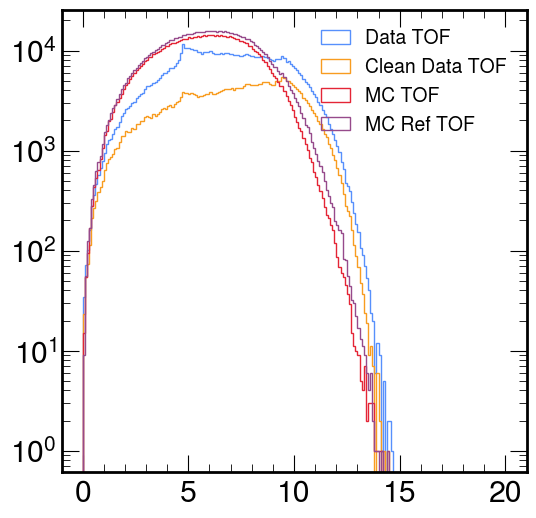

In [ ]:
run_tof = run.hit_tof
clean_run_tof = ak.mask(run_tof, run.hit_amp_mask & run.hit_charge_mask & run.hit_time_mask)
mc_tof = mc.hit_tof
mcRef_tof = mcRef.hit_tof

nbins = 200
tof_range = (0,20)

plt.figure(figsize=(6,6))
print(run_tof)
plt.hist(ak.flatten(run_tof),bins=nbins, range=tof_range, histtype='step',label='Data TOF')
plt.hist(ak.flatten(clean_run_tof),bins=nbins, range=tof_range, histtype='step',label='Clean Data TOF')
plt.hist(ak.flatten(mc_tof),bins=nbins,range=tof_range, histtype='step',label='MC TOF')
plt.hist(ak.flatten(mcRef_tof),bins=nbins, range=tof_range,histtype='step',label='MC Ref TOF')
plt.yscale('log')

plt.legend(loc='upper right',fontsize=14)


In [ ]:
# Get time residuals with seedndestroy (do this second because want to overwrite)

run.calculate_time_residuals(snd=True)
mc.calculate_time_residuals(snd=True)
mcRef.calculate_time_residuals(snd=True)

run_tres_snd = run.hit_time_res
mc_tres_snd = mc.hit_time_res
mcRef_tres_snd = mcRef.hit_time_res



fit 7823 2177
30743 [0, 17, 0, 0, 0, 0, 8, 16, 0, 11, 0, 0, ..., 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0]
fit 10000 0
0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fit 10000 0
0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


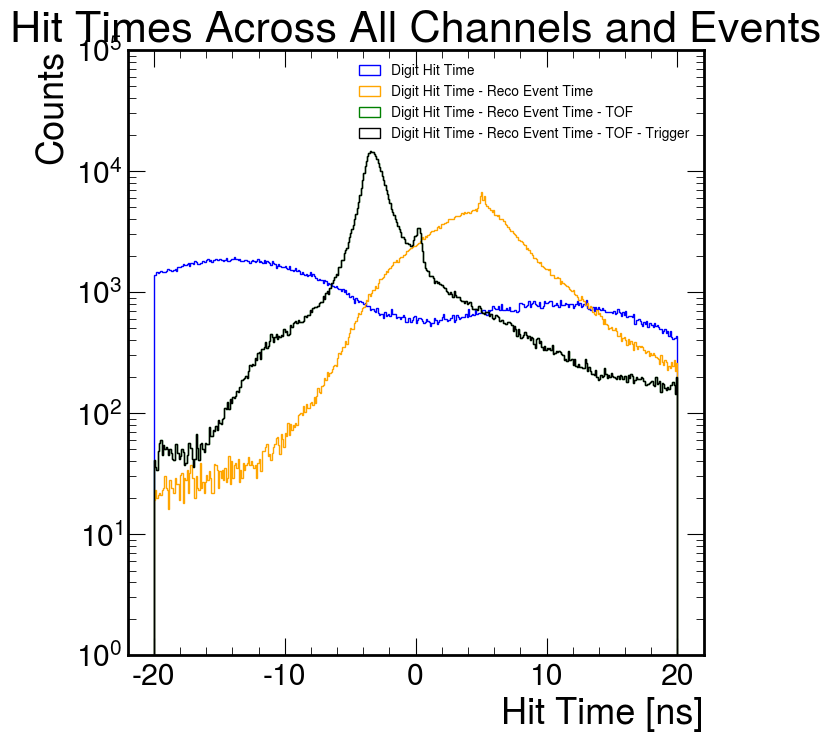

In [ ]:
test_time_cut = (-10,10)
run.plot_timing_corrections()

(10.0, 100000.0)

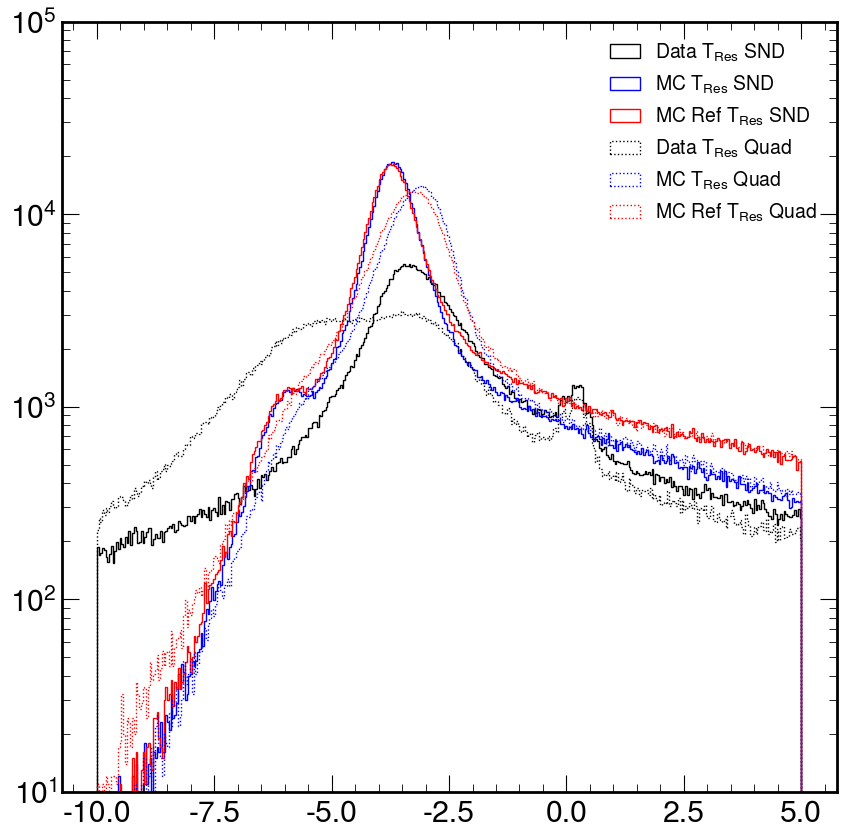

In [ ]:
nbins = 400
trange = (-10,5)

plt.figure(figsize=(10,10))
plt.hist(ak.flatten(run_tres_snd),bins=nbins,range=trange,histtype='step',color='black',label='Data $T_{Res}$ SND')
plt.hist(ak.flatten(mc_tres_snd),bins=nbins,range=trange,histtype='step',color='blue',label='MC $T_{Res}$ SND')
plt.hist(ak.flatten(mcRef_tres_snd),bins=nbins,range=trange,histtype='step',color='red',label='MC Ref $T_{Res}$ SND')
plt.hist(ak.flatten(run_tres_quad),bins=nbins,range=trange,histtype='step',color='black',linestyle=':',label='Data $T_{Res}$ Quad')
plt.hist(ak.flatten(mc_tres_quad),bins=nbins,range=trange,histtype='step',color='blue',linestyle=':',label='MC $T_{Res}$ Quad')
plt.hist(ak.flatten(mcRef_tres_quad),bins=nbins,range=trange,histtype='step',color='red',linestyle=':',label='MC Ref $T_{Res}$ Quad')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=14)
plt.ylim(1e1,1e5)

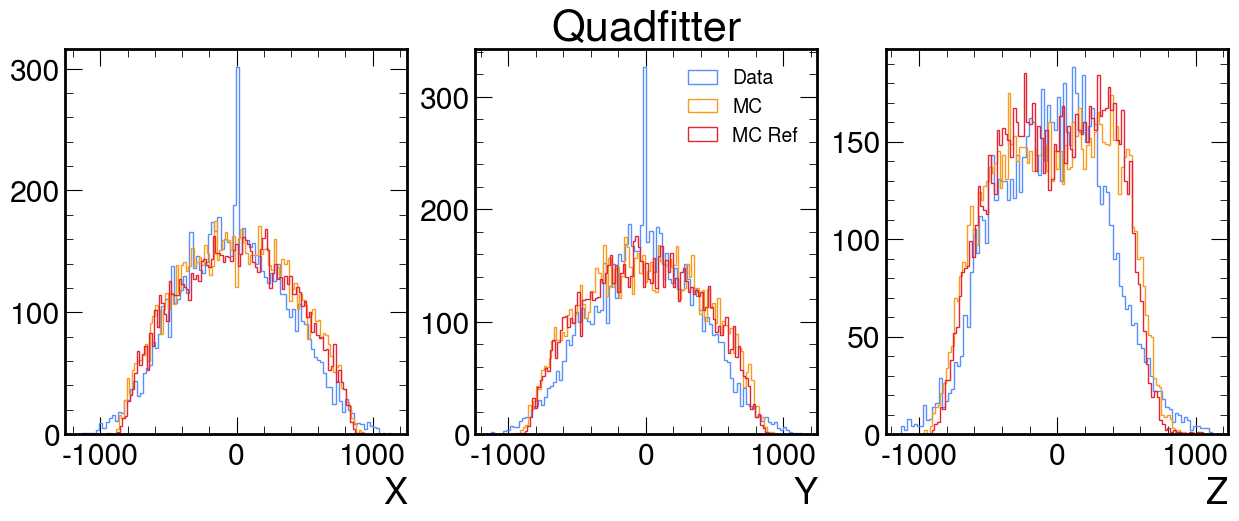

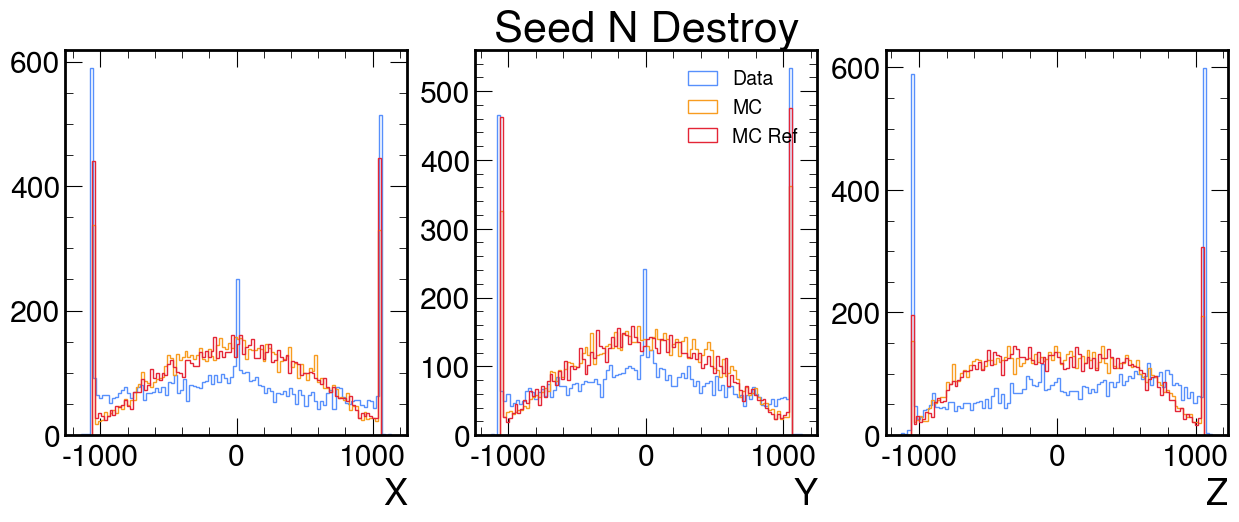

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

run_x_quad = ak.where(run.output_data['validposition_quadfitter'],run.output_data['x_quadfitter'], np.nan)
run_y_quad = ak.where(run.output_data['validposition_quadfitter'],run.output_data['y_quadfitter'], np.nan)
run_z_quad = ak.where(run.output_data['validposition_quadfitter'],run.output_data['z_quadfitter'], np.nan)

mc_x_quad = ak.where(mc.output_data['validposition_quadfitter'],mc.output_data['x_quadfitter'], np.nan)
mc_y_quad = ak.where(mc.output_data['validposition_quadfitter'],mc.output_data['y_quadfitter'], np.nan)
mc_z_quad = ak.where(mc.output_data['validposition_quadfitter'],mc.output_data['z_quadfitter'], np.nan)

mcRef_x_quad = ak.where(mcRef.output_data['validposition_quadfitter'],mcRef.output_data['x_quadfitter'], np.nan)
mcRef_y_quad = ak.where(mcRef.output_data['validposition_quadfitter'],mcRef.output_data['y_quadfitter'], np.nan)
mcRef_z_quad = ak.where(mcRef.output_data['validposition_quadfitter'],mcRef.output_data['z_quadfitter'], np.nan)

nbins=100

ax[1].set_title("Quadfitter")

ax[0].hist(run_x_quad,bins=nbins,histtype='step',label="Data")
ax[1].hist(run_y_quad,bins=nbins,histtype='step',label="Data")
ax[2].hist(run_z_quad,bins=nbins,histtype='step',label="Data");

ax[0].hist(mc_x_quad,bins=nbins,histtype='step',label="MC")
ax[1].hist(mc_y_quad,bins=nbins,histtype='step',label="MC")
ax[2].hist(mc_z_quad,bins=nbins,histtype='step',label="MC");

ax[0].hist(mcRef_x_quad,bins=nbins,histtype='step',label="MC Ref")
ax[1].hist(mcRef_y_quad,bins=nbins,histtype='step',label="MC Ref")
ax[2].hist(mcRef_z_quad,bins=nbins,histtype='step',label="MC Ref");

ax[0].set_xlabel("X")
ax[1].set_xlabel("Y")
ax[2].set_xlabel("Z")

ax[1].legend(loc='upper right',fontsize=14)
plt.show()

fig,ax = plt.subplots(1,3,figsize=(15,5))

run_x_snd = ak.where(run.output_data['validposition_quadfitter'],run.output_data['x_seedndestroy'], np.nan)
run_y_snd = ak.where(run.output_data['validposition_quadfitter'],run.output_data['y_seedndestroy'], np.nan)
run_z_snd = ak.where(run.output_data['validposition_quadfitter'],run.output_data['z_seedndestroy'], np.nan)

mc_x_snd = ak.where(mc.output_data['validposition_quadfitter'],mc.output_data['x_seedndestroy'], np.nan)
mc_y_snd = ak.where(mc.output_data['validposition_quadfitter'],mc.output_data['y_seedndestroy'], np.nan)
mc_z_snd = ak.where(mc.output_data['validposition_quadfitter'],mc.output_data['z_seedndestroy'], np.nan)

mcRef_x_snd = ak.where(mcRef.output_data['validposition_quadfitter'],mcRef.output_data['x_seedndestroy'], np.nan)
mcRef_y_snd = ak.where(mcRef.output_data['validposition_quadfitter'],mcRef.output_data['y_seedndestroy'], np.nan)
mcRef_z_snd = ak.where(mcRef.output_data['validposition_quadfitter'],mcRef.output_data['z_seedndestroy'], np.nan)

nbins=100

ax[1].set_title("Seed N Destroy")

ax[0].hist(run_x_snd,bins=nbins,histtype='step',label="Data")
ax[1].hist(run_y_snd,bins=nbins,histtype='step',label="Data")
ax[2].hist(run_z_snd,bins=nbins,histtype='step',label="Data");

ax[0].hist(mc_x_snd,bins=nbins,histtype='step',label="MC")
ax[1].hist(mc_y_snd,bins=nbins,histtype='step',label="MC")
ax[2].hist(mc_z_snd,bins=nbins,histtype='step',label="MC");

ax[0].hist(mcRef_x_snd,bins=nbins,histtype='step',label="MC Ref")
ax[1].hist(mcRef_y_snd,bins=nbins,histtype='step',label="MC Ref")
ax[2].hist(mcRef_z_snd,bins=nbins,histtype='step',label="MC Ref");

ax[0].set_xlabel("X")
ax[1].set_xlabel("Y")
ax[2].set_xlabel("Z")

ax[1].legend(loc='upper right',fontsize=14)
plt.show()

In [ ]:
from scipy import stats

mcRef_x_snd = ak.to_numpy(mcRef_x_snd)
vals, counts = np.unique(mcRef_x_snd, return_counts=True)

# Sort by frequency (descending)
sorted_idx = np.argsort(-counts)

top_k = 3
top_vals = vals[sorted_idx[:top_k]]
top_counts = counts[sorted_idx[:top_k]]

print("Top values:", top_vals)
print("Counts:", top_counts)



Top values: [-1060.  1060.  1060.]
Counts: [394 394   4]


In [ ]:

# Go backwards and see where the corrected times came from!


fit 7823 2177
30743 [0, 17, 0, 0, 0, 0, 8, 16, 0, 11, 0, 0, ..., 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0]
2767 [  189312 25314272 45399648 ... 26817600    44032   121616]
10000 [False, False, False, False, False, ..., False, False, False, False, False]
2767 [False False False ... False False False]
10000 [False False False ... False False False]
10000 [False False False ... False False False]


TypeError: to_numpy() got an unexpected keyword argument 'bins'

This error occurred while calling

    ak.to_numpy(
        <Array [-4.15, -6.79, ..., -0.0124, -0.282] type='1501 * float64'>
        bins = 200
        range = (-20, 20)
        histtype = 'step'
        label = 'bad'
    )

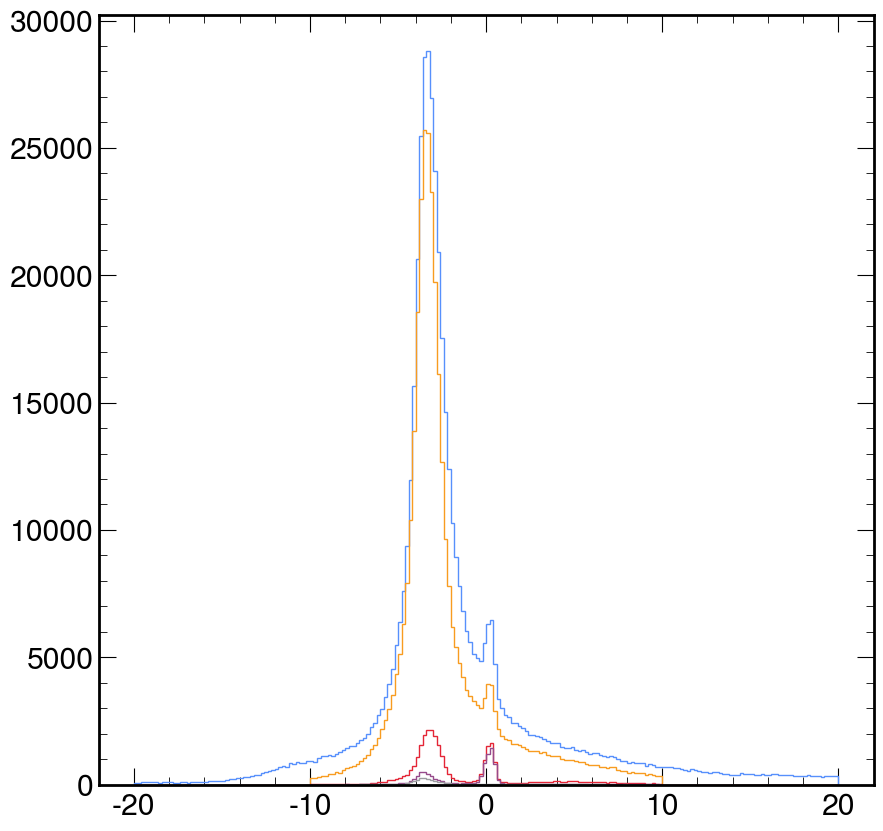

In [ ]:
run.calculate_time_residuals(snd=True)
run.make_hit_cleaning_masks(time_cut=(-10,10))
run.make_fiducial_volume_mask(snd=True,zcut=600,rcut=600)
run.make_cleaned_and_raw_nhit_masks(prompt_min_nhit=125, delayed_min_nhit=10)
run.compute_delayed_times_relative_to_prompt_with_ts()
run.make_deliverables(delayed_deltat_michel_range=(1,5),delayed_deltat_background_range=(20,40))

tres = run.hit_time_res
hc_tres = tres[run.hit_amp_mask & run.hit_charge_mask & run.hit_time_mask] 
fhc_tres = hc_tres[run.fid_vol_event_mask]
nfhc_tres = hc_tres[run.fid_vol_event_mask & run.delayed_clean_mask]
bad_nfhc_tres = hc_tres[run.fid_vol_event_mask & ~run.delayed_clean_mask & ~run.prompt_clean_mask]
fnfhc_tres = hc_tres[run.final_event_mask]


nbins = 200
trange = (-20,20)

plt.hist(ak.to_numpy(ak.flatten(tres,axis=None)),bins=nbins,range=trange, histtype='step',label='tres')
plt.hist(ak.to_numpy(ak.flatten(hc_tres,axis=None)),bins=nbins,range=trange, histtype='step',label='tres w/ hit cuts')
plt.hist(ak.to_numpy(ak.flatten(fhc_tres,axis=None)),bins=nbins,range=trange, histtype='step',label='tres w/ hit cuts w/ fidvol cut')
plt.hist(ak.to_numpy(ak.flatten(nfhc_tres,axis=None)),bins=nbins,range=trange, histtype='step',label='tres w/ hit cuts w/ fidvol cut w/ nhit cut')
plt.hist(ak.to_numpy(ak.flatten(fnfhc_tres,axis=None)),bins=nbins,range=trange, histtype='step',label='tres w/ hit cuts w/ fidvol cut w/ nhit cut w/ follower cut')
plt.hist(ak.to_numpy(ak.flatten(bad_nfhc_tres,axis=None),bins=nbins,range=trange, histtype='step',label='bad'))

plt.yscale('log')
plt.legend(loc='upper right',fontsize=10);

In [ ]:

print(np.unique(run.output_data['triggerTime']))
print(np.unique(mc.output_data['triggerTime']))

[0]
[0, 1.3, 1.35, 1.4, 1.5, 1.55, ..., 9.5, 9.7, 9.95, 12.8, 1.57e+04, 1.52e+05]
